In [ ]:
import pandas as pd

In [23]:
df = pd.read_csv("data/dnd_chars_all.tsv", sep="\t")
df.head()

,ip,finger,hash,name,race,background,date,class,justClass,subclass,...,choices,country,countryCode,processedAlignment,good,lawful,processedRace,processedSpells,processedWeapons,alias
0,NaN,ed15f9d,fe3ed6570067d2cd808bcee0a4396824,ee1e382c,Hill Dwarf,Guild Member - Justice,2022-08-23T20:02:11Z,Sorcerer 13|Cleric 1,Sorcerer|Cleric,Clockwork Soul|Order Domain,...,metamagic/Twinned Spell*Subtle Spell*Quickened...,Canada,CA,NaN,NaN,NaN,Dwarf,Alarm*1|Protection from Evil and Good*1|Comman...,"Crossbow, Light|Dagger",thirsty_davinci
1,NaN,ed15f9d,aa656cef94740b1da714d82782d8a8c4,ee1e382c,Hill Dwarf,Guild Member - Justice,2022-08-23T19:43:25Z,Sorcerer 13|Cleric 1,Sorcerer|Cleric,Clockwork Soul|Order Domain,...,metamagic/Twinned Spell*Subtle Spell*Quickened...,Canada,CA,NaN,NaN,NaN,Dwarf,Alarm*1|Protection from Evil and Good*1|Comman...,"Crossbow, Light|Dagger",thirsty_davinci
2,6b5d3f4,d922658,04b9abba9ce759ef13319c520bf0eb69,f1f6ff43,Human,Noble,2022-08-22T14:57:09Z,Fighter 13,Fighter,Eldritch Knight,...,fighting style/Defense,United States,US,CG,NaN,NaN,Human,Prestidigitation*0|Mage Hand*0|Blade Ward*0|Li...,"Longsword|Dagger|Crossbow, Light|Mace",cool_bhabha
3,9b7218f,b5d19a0,ba92372c716a832e03e866447cb2d102,f92bdd74,Fallen Aasimar,Outlander,2022-08-22T12:12:53Z,Sorcerer 3|Druid 2,Sorcerer|Druid,Shadow Magic|Circle of Wildfire,...,metamagic/Transmuted Spell*Seeking Spell,Brazil,BR,NaN,NaN,NaN,Aasimar,Burning Hands*1|Cure Wounds*1|Darkness*2,Dagger,vigilant_mcclintock
4,9b7218f,b5d19a0,2f4a637dd42b9aa945abf870fe34edcf,f92bdd74,Fallen Aasimar,Outlander,2022-08-22T12:07:21Z,Sorcerer 3|Druid 2,Sorcerer|Druid,Shadow Magic|Circle of Wildfire,...,metamagic/Transmuted Spell*Seeking Spell,Brazil,BR,NaN,NaN,NaN,Aasimar,Burning Hands*1|Cure Wounds*1|Darkness*2,Dagger,vigilant_mcclintock


In [24]:
df.drop(columns=["ip", "finger", "hash"], inplace=True)

In [ ]:
df.head()

In [25]:
cdf = df.dropna(subset=["justClass", "race"]).copy()
cdf["justClass_expanded"] = cdf["justClass"].str.split("|")
cdf_expand = cdf.explode("justClass_expanded")
cdf_expand["normalized_race"] = cdf_expand["race"].str.strip().str.lower()
cdf_expand["normalized_class"] = cdf_expand["justClass_expanded"].str.strip().str.lower()
cdf_expand.head()

,name,race,background,date,class,justClass,subclass,level,feats,HP,...,processedAlignment,good,lawful,processedRace,processedSpells,processedWeapons,alias,justClass_expanded,normalized_race,normalized_class
0,ee1e382c,Hill Dwarf,Guild Member - Justice,2022-08-23T20:02:11Z,Sorcerer 13|Cleric 1,Sorcerer|Cleric,Clockwork Soul|Order Domain,14,Fey Touched|War Caster|Metamagic Adept,146,...,NaN,NaN,NaN,Dwarf,Alarm*1|Protection from Evil and Good*1|Comman...,"Crossbow, Light|Dagger",thirsty_davinci,Sorcerer,hill dwarf,sorcerer
0,ee1e382c,Hill Dwarf,Guild Member - Justice,2022-08-23T20:02:11Z,Sorcerer 13|Cleric 1,Sorcerer|Cleric,Clockwork Soul|Order Domain,14,Fey Touched|War Caster|Metamagic Adept,146,...,NaN,NaN,NaN,Dwarf,Alarm*1|Protection from Evil and Good*1|Comman...,"Crossbow, Light|Dagger",thirsty_davinci,Cleric,hill dwarf,cleric
1,ee1e382c,Hill Dwarf,Guild Member - Justice,2022-08-23T19:43:25Z,Sorcerer 13|Cleric 1,Sorcerer|Cleric,Clockwork Soul|Order Domain,14,NaN,133,...,NaN,NaN,NaN,Dwarf,Alarm*1|Protection from Evil and Good*1|Comman...,"Crossbow, Light|Dagger",thirsty_davinci,Sorcerer,hill dwarf,sorcerer
1,ee1e382c,Hill Dwarf,Guild Member - Justice,2022-08-23T19:43:25Z,Sorcerer 13|Cleric 1,Sorcerer|Cleric,Clockwork Soul|Order Domain,14,NaN,133,...,NaN,NaN,NaN,Dwarf,Alarm*1|Protection from Evil and Good*1|Comman...,"Crossbow, Light|Dagger",thirsty_davinci,Cleric,hill dwarf,cleric
2,f1f6ff43,Human,Noble,2022-08-22T14:57:09Z,Fighter 13,Fighter,Eldritch Knight,13,Heavy Armor Master,140,...,CG,NaN,NaN,Human,Prestidigitation*0|Mage Hand*0|Blade Ward*0|Li...,"Longsword|Dagger|Crossbow, Light|Mace",cool_bhabha,Fighter,human,fighter


In [32]:
len(cdf_expand[cdf_expand["normalized_race"] == "birdfolk"])

46

In [ ]:
import matplotlib.pyplot as plt

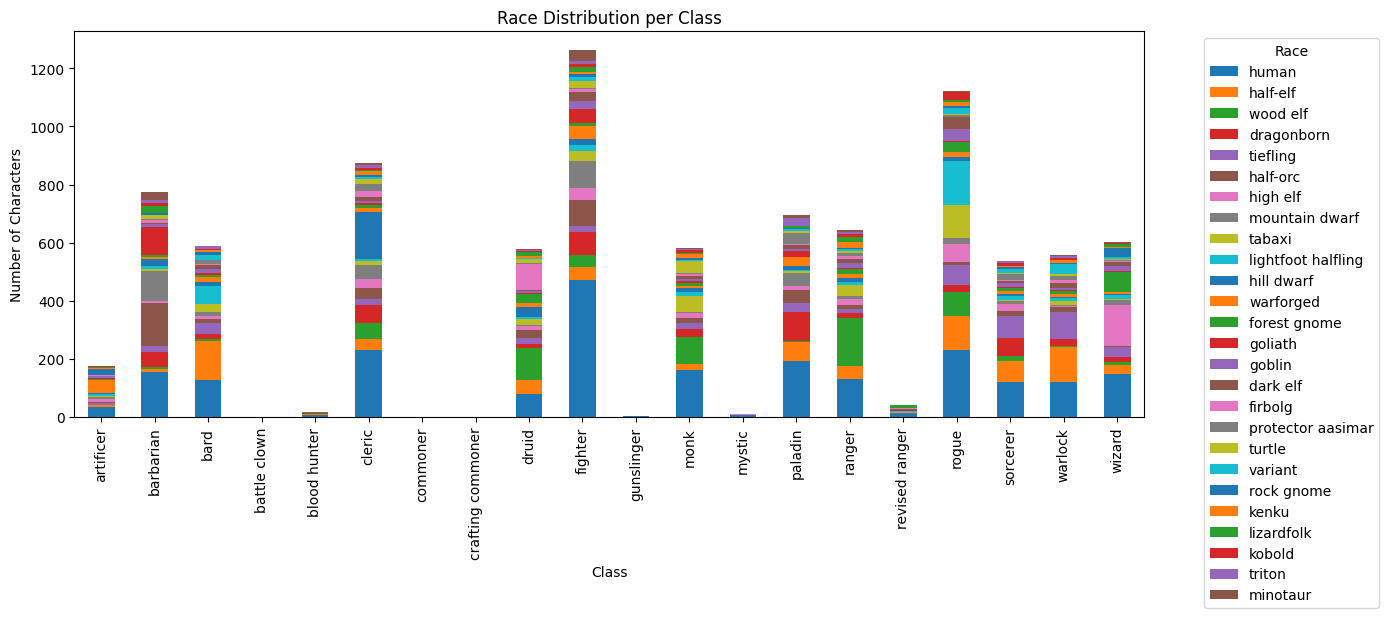

In [36]:

race_counts = cdf_expand["normalized_race"].value_counts()
races_to_keep = race_counts[race_counts > 100].index
pivot_table = pd.crosstab(cdf_expand["normalized_race"], cdf_expand["normalized_class"])
pivot_table_clean = pivot_table.loc[races_to_keep]
pivot_table_clean.T.plot(kind='bar', stacked=True, figsize=(14, 6))
plt.title("Race Distribution per Class")
plt.xlabel("Class")
plt.ylabel("Number of Characters")
plt.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
cdf_expand

# Take race, normalized_race, processedAlignment to predict justClass_expanded
training_data = []

,name,race,background,date,class,justClass,subclass,level,feats,HP,...,processedAlignment,good,lawful,processedRace,processedSpells,processedWeapons,alias,justClass_expanded,normalized_race,normalized_class
0,ee1e382c,Hill Dwarf,Guild Member - Justice,2022-08-23T20:02:11Z,Sorcerer 13|Cleric 1,Sorcerer|Cleric,Clockwork Soul|Order Domain,14,Fey Touched|War Caster|Metamagic Adept,146,...,NaN,NaN,NaN,Dwarf,Alarm*1|Protection from Evil and Good*1|Comman...,"Crossbow, Light|Dagger",thirsty_davinci,Sorcerer,hill dwarf,sorcerer
0,ee1e382c,Hill Dwarf,Guild Member - Justice,2022-08-23T20:02:11Z,Sorcerer 13|Cleric 1,Sorcerer|Cleric,Clockwork Soul|Order Domain,14,Fey Touched|War Caster|Metamagic Adept,146,...,NaN,NaN,NaN,Dwarf,Alarm*1|Protection from Evil and Good*1|Comman...,"Crossbow, Light|Dagger",thirsty_davinci,Cleric,hill dwarf,cleric
1,ee1e382c,Hill Dwarf,Guild Member - Justice,2022-08-23T19:43:25Z,Sorcerer 13|Cleric 1,Sorcerer|Cleric,Clockwork Soul|Order Domain,14,NaN,133,...,NaN,NaN,NaN,Dwarf,Alarm*1|Protection from Evil and Good*1|Comman...,"Crossbow, Light|Dagger",thirsty_davinci,Sorcerer,hill dwarf,sorcerer
1,ee1e382c,Hill Dwarf,Guild Member - Justice,2022-08-23T19:43:25Z,Sorcerer 13|Cleric 1,Sorcerer|Cleric,Clockwork Soul|Order Domain,14,NaN,133,...,NaN,NaN,NaN,Dwarf,Alarm*1|Protection from Evil and Good*1|Comman...,"Crossbow, Light|Dagger",thirsty_davinci,Cleric,hill dwarf,cleric
2,f1f6ff43,Human,Noble,2022-08-22T14:57:09Z,Fighter 13,Fighter,Eldritch Knight,13,Heavy Armor Master,140,...,CG,NaN,NaN,Human,Prestidigitation*0|Mage Hand*0|Blade Ward*0|Li...,"Longsword|Dagger|Crossbow, Light|Mace",cool_bhabha,Fighter,human,fighter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10889,6f906508,Tiefling,Hermit,2018-04-07T19:49:23Z,Monk 3,Monk,Way of the Drunken Master,3,NaN,25,...,NaN,NaN,NaN,Tiefling,NaN,Quarterstaff|Dart|Unarmed Strike,nervous_goldstine,Monk,tiefling,monk
10890,bcf1fa28,Half-Elf,Mercenary Veteran,2018-04-07T15:40:55Z,Ranger 3,Ranger,Beast Master,3,NaN,32,...,NaN,NaN,NaN,Half-Elf,NaN,"Shortsword|Crossbow, Light",gallant_hugle,Ranger,half-elf,ranger
10891,5fcc1db9,Dragonborn,Noble,2018-04-07T09:21:55Z,Paladin 6,Paladin,Oath of Ancients,6,NaN,58,...,CG,NaN,NaN,Dragonborn,Ensnaring Strike*1|Speak with Animals*1|Cure W...,Longsword|Javelin,condescending_lederberg,Paladin,dragonborn,paladin
10892,acc2a5e1,Meadowguard,Acolyte,2018-04-07T08:04:10Z,Bard 1,Bard,NaN,1,NaN,10,...,NaN,NaN,NaN,NaN,Mending*0|Light*0|Minor Illusion*0|Heroism*1|H...,Dagger|Dagger,relaxed_cori,Bard,meadowguard,bard
